In [90]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users


In [91]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.av_dataset import Dataset

In [92]:
avdf_all = Dataset().get_data()
avdf_ran = Dataset().get_data(use_robust_av = False, control_types=['ran'])
avdf_moi = Dataset().get_data(use_robust_av = False, control_types=['moi'])
avdf_ems = Dataset().get_data(use_robust_av = False, control_types=['ems'])

clean_data kwargs {'use_robust_av': True}
read all the csvs...
 ['analysisvariables.csv']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.87it/s]

preprocess_data kwargs {'frac_missing_allowed': 0.05}
split_data kwargs {'control_types': ['ran', 'moi', 'ems']}
['ran', 'moi', 'ems']



/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


clean_data kwargs {'use_robust_av': False}
read all the csvs...
 ['analysisvariables.csv']


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 134.75it/s]

preprocess_data kwargs {'frac_missing_allowed': 0.05}
split_data kwargs {'control_types': ['ran']}
['ran']



/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


split_data kwargs {'control_types': ['moi']}
['moi']
split_data kwargs {'control_types': ['ems']}
['ems']


In [93]:
avdf_ran_train = avdf_ran[0]
avdf_ran_tuning = avdf_ran[1]
avdf_ran_testing = avdf_ran[2]

In [94]:
print(avdf_ran_train.shape)
print(avdf_ran_tuning.shape)
print(avdf_ran_testing.shape)

(821, 23)
(279, 23)
(290, 23)


### Variable selection by tree-based methods

In [125]:
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [206]:
# data preparation

X = avdf_ran_train.loc[:,'LOC':'NonAmbulatory']
y = avdf_ran_train['csi_injury'].astype('int')
X_tuning = avdf_ran_tuning.loc[:,'LOC':'NonAmbulatory']
y_tuning = avdf_ran_tuning['csi_injury'].astype('int')

d = {'name':X.columns}
VI_df = pd.DataFrame(data = d)

In [207]:
# cart with default setting
cart = tree.DecisionTreeClassifier()
cart = cart.fit(X,y)

VI_df['cart_dini'] = (-cart.feature_importances_).argsort().argsort()

perm1 = permutation_importance(cart, X, y, n_repeats = 20, random_state = 1)
VI_df['cart_perm_train'] = (-perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(cart, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['cart_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

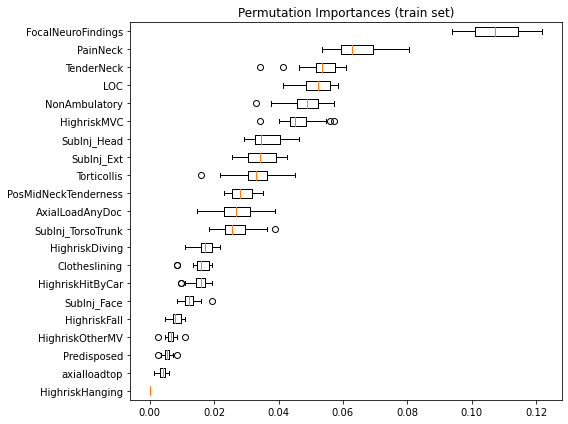

In [210]:
# variable selection by permutation 
result = permutation_importance(cart, X, y, n_repeats = 20, random_state = 1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [213]:
rf = RandomForestClassifier()
rf = rf.fit(X,y)

VI_df['rf_dini'] = (-rf.feature_importances_).argsort().argsort()

perm1 = permutation_importance(rf, X, y, n_repeats = 20, random_state = 1)
VI_df['rf_perm_train'] = (-perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(rf, X_tuning, y_tuning, n_repeats = 20, random_state = 1)
VI_df['rf_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()
VI_df = VI_df.assign(ave_rank = VI_df.mean(axis = 1))

In [214]:
VI_df.sort_values(by = 'ave_rank')

,name,cart_dini,cart_perm_train,cart_perm_tuning,rf_dini,rf_perm_train,rf_perm_tuning,ave_rank
1,FocalNeuroFindings,0,0,0,0,0,0,0.000000
0,LOC,1,3,2,1,1,1,1.595238
20,NonAmbulatory,2,4,1,2,3,6,2.976190
2,PainNeck,7,1,3,5,2,13,4.809524
15,HighriskMVC,8,5,7,4,4,4,5.738095
11,HighriskDiving,5,12,5,8,11,2,7.214286
5,Torticollis,12,8,4,11,6,3,7.333333
8,SubInj_Ext,4,7,12,7,9,5,7.380952
6,SubInj_Head,14,6,8,6,7,9,8.571429
17,AxialLoadAnyDoc,3,10,16,3,5,20,9.547619


In [224]:
# cart with max_depth parameter
cart2 = tree.DecisionTreeClassifier(max_depth = 4)
cart2 = cart2.fit(X,y)

# VI_df['cart2_dini'] = (-cart2.feature_importances_).argsort().argsort()

# perm = permutation_importance(cart2, X, y, n_repeats=20, random_state=42)
# VI_df['cart2_perm_train'] = (-perm.importances_mean).argsort().argsort()
# perm = permutation_importance(cart2, X_tuning, y_tuning, n_repeats=10, random_state=42)
# VI_df['cart2_perm_tuning'] = (-perm.importances_mean).argsort().argsort()

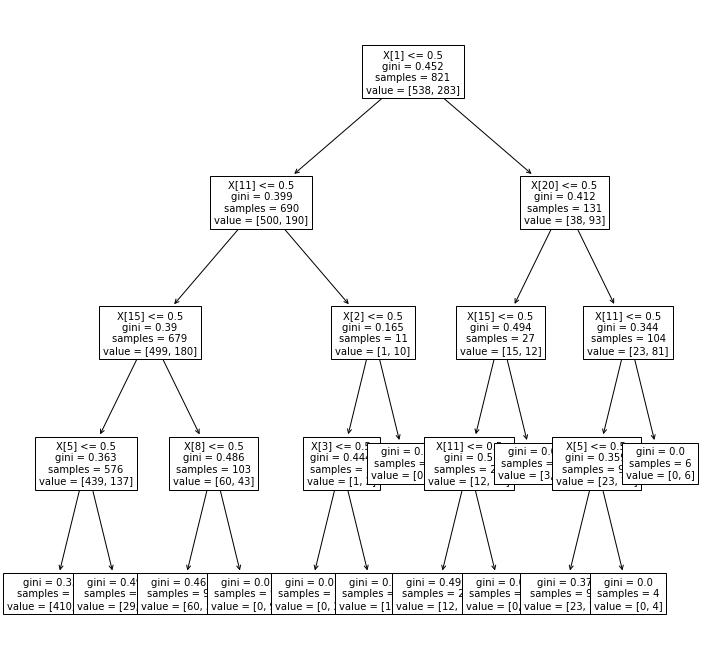

In [225]:
# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(cart2, fontsize=10)
plt.show()

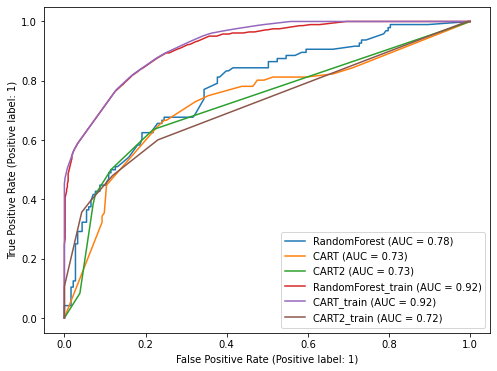

In [226]:
# ax = plt.gca()
fig, ax = plt.subplots(figsize=(8,6))
rf_disp = RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
cart_disp = RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
cart2_disp = RocCurveDisplay.from_estimator(cart2, X_tuning, y_tuning, ax=ax, name = "CART2")
rf_disp_train = RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest_train")
cart_disp_train = RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART_train")
cart2_disp_train = RocCurveDisplay.from_estimator(cart2, X, y, ax=ax, name = "CART2_train")
plt.show()